# Project 1

    We begin by loading the data

In [1]:

from preprocessing_functions import *
%matplotlib inline 
import numpy as np   # generic stuff
import matplotlib.pyplot as plt

#### REMOVE THIS LINE BEFORE SUBMISSION
import pandas as pd
#######################################################################

from lib.proj1_helpers import * #the helper provided for the project
from lib.costs import *

# choose which implementations you would like
from lib.implementations import *
#from implementations import * #our implementations of the functions done by us


import datetime
from helpers import * #helpers of exo 2
# Useful starting lines

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
DATA_FOLDER = 'data/'

y_train, tx_train, ids_train = load_csv_data(DATA_FOLDER+'train.csv',sub_sample=True)

y_test, tx_test, ids_test = load_csv_data(DATA_FOLDER+'test.csv',sub_sample=True)
AAA = 0;

note that here we are only considering a sub_sample as the "True" value indicates

In [4]:
y_train

array([ 1., -1., -1., ...,  1., -1.,  1.])

In [5]:
ids_train
np.mean(tx_train,axis=0)

array([ -6.65702052e+01,   5.02655292e+01,   8.10068096e+01,
         5.72432294e+01,  -7.03584253e+02,  -5.96237100e+02,
        -7.04529779e+02,   2.37571420e+00,   1.89751598e+01,
         1.57925417e+02,   1.44750460e+00,  -1.58575000e-01,
        -7.04154751e+02,   3.79714208e+01,  -7.52940000e-03,
        -7.32000000e-05,   4.63404222e+01,  -1.99772000e-02,
         1.15077200e-01,   4.22103976e+01,   2.86580000e-02,
         2.09378977e+02,   9.84400000e-01,  -3.45453367e+02,
        -3.96614008e+02,  -3.96605099e+02,  -6.87271262e+02,
        -7.04296892e+02,  -7.04330749e+02,   7.36135732e+01])

In [6]:
# illegal: 
pd.DataFrame(tx_train).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,-0.277,258.733,2.0,67.435,2.150,0.444,46.062,1.240,-2.475,113.497
1,219.057,72.461,124.835,5.506,-999.00,-999.000,-999.000,3.771,46.936,122.986,...,0.960,90.355,1.0,50.396,-0.708,-0.642,-999.000,-999.000,-999.000,50.396
2,90.801,27.787,65.373,55.978,-999.00,-999.000,-999.000,2.457,20.608,138.624,...,0.880,219.339,1.0,62.766,0.778,-2.209,-999.000,-999.000,-999.000,62.766
3,128.167,52.145,86.912,103.373,0.90,47.636,4.808,2.277,1.936,212.505,...,2.802,292.582,2.0,72.406,-2.689,-0.295,31.252,-1.788,-0.287,103.658
4,107.067,1.939,70.444,54.621,-999.00,-999.000,-999.000,2.079,30.366,151.198,...,1.190,290.199,1.0,66.634,-0.359,-0.485,-999.000,-999.000,-999.000,66.634


### Helper functions

In [12]:
deg=9;
tx_train,tx_test = prepare_data(tx_train, tx_test, deg);

Cleaning features
Keeping unique cols
Standardizing
Cross products
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Adding powers
Adding ones


In [13]:
np.mean(tx_train,axis=0)

array([ -3.02794638e-02,   3.33198046e-04,  -1.04006068e-02,
         5.95164328e-02,  -3.97333473e-04,   9.01828401e-02,
        -2.83900680e-04,  -9.49471673e-04,   1.86900037e-02,
         1.32635270e-01,   5.81288413e-04,  -1.07312813e-03,
         3.43287150e-04,  -1.13006723e-03,  -1.59894953e-03,
         2.77282616e-03,   1.35215996e-02,  -2.36081542e-03,
        -2.29997460e-03,   3.03231035e-02,  -2.13106735e-03,
         2.04144908e-01,   8.84859057e-04,   4.61426263e-02,
        -8.82311692e-04,  -7.35675922e-04,   2.80021898e-02,
        -1.29873568e-03,   1.53536038e-03,   1.20244384e-01,
         3.04207048e+02,   1.85643822e+03,   1.62274058e+02,
        -9.19706518e-01,  -1.68814032e+02,   1.11529528e+00,
         2.00417598e+01,   1.23022825e+01,   7.17836219e+02,
         2.25169691e+00,   1.34709716e+00,  -2.49138009e-01,
         2.84937438e+02,   1.57488313e+00,   1.78512824e-01,
         3.44460997e+02,  -1.14050172e+00,   3.26644824e+00,
         1.65458728e+02,

In [14]:
tx_train.shape

(5000, 706)

In [15]:
initial_w = np.zeros(tx_train.shape[1])
initial_w.shape

(706,)

In [16]:
gamma = 0.05
max_iters = 1000
lambda_ = 0.5

# Methods

### Functions for methods: 

In [17]:
OUT_FOLDER = 'output/'

def func_least_squares (y, tx, test_set, fct='mse'):
    name = 'least_squares'
    w,loss = least_squares(y,tx,fct)
    y_pred = predict_labels(w, test_set)
    create_csv_submission(ids_test, y_pred, OUT_FOLDER+name)
    
    plt.plot(w, 'go')
    plt.title('least squares weights for loss:  '+str(loss),fontsize=15, fontweight='bold');
    plt.show()
    
    return w, loss

def func_GD (y, tx, test_set, max_iters, gamma, initial_w):
    name = 'Gradient_descent'
    w,loss = least_squares_GD(y, tx, initial_w, max_iters, gamma,fct='mse');
    y_pred = predict_labels(w, test_set)
    create_csv_submission(ids_test, y_pred, OUT_FOLDER+name)
    
    plt.plot(w, 'go')
    plt.title('GD: weights with loss:  '+str(loss),fontsize=15, fontweight='bold');
    plt.show()
    
    return w, loss

########################  RIDGE REGRESSION #######################################################
def func_ridge_regression (y, tx, test_set, lambda_):
    name = 'Ridge_regression'
    
    w,loss = ridge_regression(y, tx, lambda_=lambda_, fct='mse');
    
    y_pred = predict_labels(w, test_set)
    create_csv_submission(ids_test, y_pred, OUT_FOLDER+name)
    
    plt.plot(w, 'go')
    plt.title('Ridge regression: weights ;loss:  '+str(loss),fontsize=15, fontweight='bold');
    plt.show()
    
    return w, loss

## LEAST-SQUARES

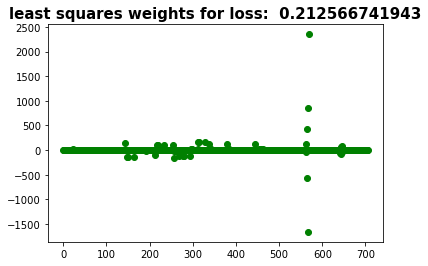

In [18]:
w, loss = func_least_squares (y=y_train, tx=tx_train, test_set=tx_test, fct='mse');


In [19]:
y_pred_train = predict_labels(w, tx_train)
right_train = np.sum(y_pred_train == y_train)/len(y_train)*100
right_train

86.460000000000008

## Gradient descent 

In [20]:
w, loss = func_GD (y=y_train, tx=tx_train, test_set=tx_test, max_iters=500,gamma=0.1, initial_w=initial_w);


Gradient Descent(0/499): loss=0.5000000000000004, w0=0.07865693408977247, w1=-1.174452544260258
Gradient Descent(1/499): loss=3.2185262255688604e+111, w0=-2.1883188450052752e+54, w1=8.402427347023627e+54
Gradient Descent(2/499): loss=2.586811580888404e+226, w0=6.203895641523393e+111, w1=-2.3820925603231666e+112
Gradient Descent(3/499): loss=inf, w0=-1.7588076903872944e+169, w1=6.753244987341451e+169
Gradient Descent(4/499): loss=inf, w0=4.986229089768977e+226, w1=-1.9145485200149164e+227
Gradient Descent(5/499): loss=inf, w0=-1.4135985799666138e+284, w1=5.427755164164871e+284
Gradient Descent(6/499): loss=nan, w0=nan, w1=nan
Gradient Descent(7/499): loss=nan, w0=nan, w1=nan
Gradient Descent(8/499): loss=nan, w0=nan, w1=nan
Gradient Descent(9/499): loss=nan, w0=nan, w1=nan
Gradient Descent(10/499): loss=nan, w0=nan, w1=nan
Gradient Descent(11/499): loss=nan, w0=nan, w1=nan
Gradient Descent(12/499): loss=nan, w0=nan, w1=nan
Gradient Descent(13/499): loss=nan, w0=nan, w1=nan
Gradient Desc

Gradient Descent(163/499): loss=nan, w0=nan, w1=nan
Gradient Descent(164/499): loss=nan, w0=nan, w1=nan
Gradient Descent(165/499): loss=nan, w0=nan, w1=nan
Gradient Descent(166/499): loss=nan, w0=nan, w1=nan
Gradient Descent(167/499): loss=nan, w0=nan, w1=nan
Gradient Descent(168/499): loss=nan, w0=nan, w1=nan
Gradient Descent(169/499): loss=nan, w0=nan, w1=nan
Gradient Descent(170/499): loss=nan, w0=nan, w1=nan
Gradient Descent(171/499): loss=nan, w0=nan, w1=nan
Gradient Descent(172/499): loss=nan, w0=nan, w1=nan
Gradient Descent(173/499): loss=nan, w0=nan, w1=nan
Gradient Descent(174/499): loss=nan, w0=nan, w1=nan
Gradient Descent(175/499): loss=nan, w0=nan, w1=nan
Gradient Descent(176/499): loss=nan, w0=nan, w1=nan
Gradient Descent(177/499): loss=nan, w0=nan, w1=nan
Gradient Descent(178/499): loss=nan, w0=nan, w1=nan
Gradient Descent(179/499): loss=nan, w0=nan, w1=nan
Gradient Descent(180/499): loss=nan, w0=nan, w1=nan
Gradient Descent(181/499): loss=nan, w0=nan, w1=nan
Gradient Des

Gradient Descent(328/499): loss=nan, w0=nan, w1=nan
Gradient Descent(329/499): loss=nan, w0=nan, w1=nan
Gradient Descent(330/499): loss=nan, w0=nan, w1=nan
Gradient Descent(331/499): loss=nan, w0=nan, w1=nan
Gradient Descent(332/499): loss=nan, w0=nan, w1=nan
Gradient Descent(333/499): loss=nan, w0=nan, w1=nan
Gradient Descent(334/499): loss=nan, w0=nan, w1=nan
Gradient Descent(335/499): loss=nan, w0=nan, w1=nan
Gradient Descent(336/499): loss=nan, w0=nan, w1=nan
Gradient Descent(337/499): loss=nan, w0=nan, w1=nan
Gradient Descent(338/499): loss=nan, w0=nan, w1=nan
Gradient Descent(339/499): loss=nan, w0=nan, w1=nan
Gradient Descent(340/499): loss=nan, w0=nan, w1=nan
Gradient Descent(341/499): loss=nan, w0=nan, w1=nan
Gradient Descent(342/499): loss=nan, w0=nan, w1=nan
Gradient Descent(343/499): loss=nan, w0=nan, w1=nan
Gradient Descent(344/499): loss=nan, w0=nan, w1=nan
Gradient Descent(345/499): loss=nan, w0=nan, w1=nan
Gradient Descent(346/499): loss=nan, w0=nan, w1=nan
Gradient Des

Gradient Descent(493/499): loss=nan, w0=nan, w1=nan
Gradient Descent(494/499): loss=nan, w0=nan, w1=nan
Gradient Descent(495/499): loss=nan, w0=nan, w1=nan
Gradient Descent(496/499): loss=nan, w0=nan, w1=nan
Gradient Descent(497/499): loss=nan, w0=nan, w1=nan
Gradient Descent(498/499): loss=nan, w0=nan, w1=nan
Gradient Descent(499/499): loss=nan, w0=nan, w1=nan


/Users/matteociprian/Documents/GitHub/LMO_ML/project1/A_final/lib/proj1_helpers.py:30: RuntimeWarning: invalid value encountered in less_equal
  y_pred[np.where(y_pred <= 0)] = -1
/Users/matteociprian/Documents/GitHub/LMO_ML/project1/A_final/lib/proj1_helpers.py:31: RuntimeWarning: invalid value encountered in greater
  y_pred[np.where(y_pred > 0)] = 1


ValueError: cannot convert float NaN to integer

In [19]:
w.shape
tx_train.shape

(250000, 31)

In [20]:
y_pred_train = predict_labels(w, tx_train)
right_train = np.sum(y_pred_train == y_train)/len(y_train)*100
right_train

74.495599999999996

## Ridge regression   

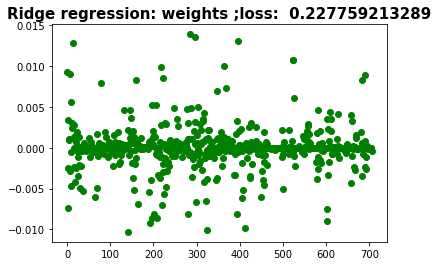

In [21]:
[w,loss]=func_ridge_regression (y=y_train, tx=tx_train, test_set=tx_test, lambda_=lambda_);

In [22]:
y_pred_train = predict_labels(w, tx_train)
right_train = np.sum(y_pred_train == y_train)/len(y_train)*100
right_train

85.280000000000001

##  SGD

In [23]:
def func_SGD (y, tx, test_set, max_iters, gamma, initial_w, batch_size):
    name = 'Stochastic_Gradient_descent'
    
    w,loss = least_squares_SGD(y, tx, initial_w, max_iters,\
                               gamma, batch_size)
    
    y_pred = predict_labels(w, test_set)
    create_csv_submission(ids_test, y_pred, OUT_FOLDER+name)
    
    plt.plot(w, 'go')
    plt.title('SGD: weights with loss:  '+str(loss),fontsize=15, fontweight='bold');
    plt.show()
    
    return w, loss

In [24]:
w, loss = func_SGD (y=y_train, tx=tx_train, test_set=tx_test, max_iters=10,gamma=gamma, initial_w=initial_w,\
                   batch_size=5);

/Users/matteociprian/Documents/GitHub/LMO_ML/project1/A_final/lib/proj1_helpers.py:30: RuntimeWarning: invalid value encountered in less_equal
  y_pred[np.where(y_pred <= 0)] = -1
/Users/matteociprian/Documents/GitHub/LMO_ML/project1/A_final/lib/proj1_helpers.py:31: RuntimeWarning: invalid value encountered in greater
  y_pred[np.where(y_pred > 0)] = 1


ValueError: cannot convert float NaN to integer

## LOGISTIC REGRESSION

In [25]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation_logistic_regression(y,tx, k_fold, max_iters, gammas):
    
    accuracies=np.zeros(len(gammas))
    acc_max=0;
    gamma_best=0;
    
    for i, single_gamma in enumerate(gammas):
        
        seed=1;

        # get k'th subgroup in test, others in train
        k_indices = build_k_indices(y, k_fold, seed)
        accuracy_train = np.zeros(k_fold)
        accuracy_test = np.zeros(k_fold)


        for k in range(k_fold):
            #print('----- FOLD', k, '-----')
            k_index = k_indices[k]
            test_y = y[k_index]
            test_tx = tx[k_index,:]

            mask = np.ones(len(y), dtype=bool) # set all elements to True
            mask[k_index] = False              # set test elements to False
            train_tx = tx[mask,:]              # select only True elements (ie train elements)
            train_y = y[mask]
            weights,loss = logistic_regression(train_y, train_tx, initial_w, max_iters, single_gamma)
            # Compute the predictions
            y_pred_train = predict_labels(weights, train_tx)
            y_pred_test = predict_labels(weights, test_tx)
            predictions=True;
            accuracy_train[k] = np.sum(y_pred_train == train_y)/len(train_y)
            accuracy_test[k] = np.sum(y_pred_test == test_y)/len(test_y)
        accuracies[i]=np.mean(accuracy_test);
        
        print('GAMMA:', single_gamma, '---','ACCURANCY:',accuracies[i])
        if (accuracies[i]>acc_max):
                gamma_best=gammas[i];
                acc_max=accuracies[i];
    
    return gamma_best,acc_max
               
        # Compute accuracy of the predictions

        

In [26]:
gammas=np.linspace(0.00001,0.9,10);
k_fold=2;
max_iters=1000;

best_gamma,acc_max=cross_validation_logistic_regression(y_train,tx_train, k_fold, max_iters, gammas)
print('BEST GAMMA:', best_gamma, '---','ACCURANCY:',acc_max)

GAMMA: 1e-05 --- ACCURANCY: 0.4644
GAMMA: 0.100008888889 --- ACCURANCY: 0.4644
GAMMA: 0.200007777778 --- ACCURANCY: 0.4644
GAMMA: 0.300006666667 --- ACCURANCY: 0.4644
GAMMA: 0.400005555556 --- ACCURANCY: 0.4644
GAMMA: 0.500004444444 --- ACCURANCY: 0.4644
GAMMA: 0.600003333333 --- ACCURANCY: 0.4644
GAMMA: 0.700002222222 --- ACCURANCY: 0.4644
GAMMA: 0.800001111111 --- ACCURANCY: 0.4644
GAMMA: 0.9 --- ACCURANCY: 0.4644
BEST GAMMA: 1e-05 --- ACCURANCY: 0.4644


In [27]:
def func_logistic (y, tx, test_set, max_iters, gamma, initial_w):
    name = 'Logistic regression'
    
    #w,loss = logistic_regression(y, tx, initial_w, max_iters, gamma)
    w,loss = logistic_regression(y, tx, initial_w, max_iters, gamma)
    
    loss=loss/len(y);
    y_pred = predict_labels(w, test_set)
    create_csv_submission(ids_test, y_pred, OUT_FOLDER+name)  
    
    plt.plot(w, 'go')
    plt.title('logistic reg: weights with loss:  '+str(loss),fontsize=15, fontweight='bold');
    plt.show()
    
    return w, loss

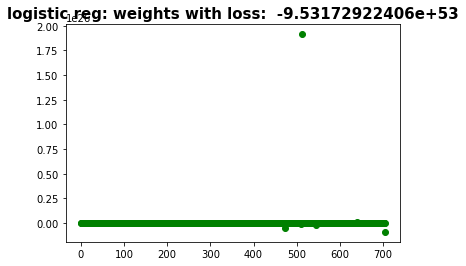

In [30]:
w, loss = func_logistic (y=y_train, tx=tx_train, test_set=tx_test, max_iters=1000,\
                         gamma=best_gamma, initial_w=initial_w);

In [31]:
y_pred_train = predict_labels(w, tx_train)
right_train = np.sum(y_pred_train == y_train)/len(y_train)*100
right_train

59.019999999999996

## LOGISTIC REGULARIZED

In [30]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation_logistic_regression_reg(y,tx, k_fold, max_iters, gammas,lambdas):
    
    acc_max=0;
    accurancies=np.zeros([len(gammas),len(lambdas)]);
    for i, single_gamma in enumerate(gammas):
        for j, single_lambda in enumerate(lambdas):
            seed=1;
        
            # get k'th subgroup in test, others in train
            k_indices = build_k_indices(y, k_fold, seed)
            accuracy_train = np.zeros(k_fold)
            accuracy_test = np.zeros(k_fold)


            for k in range(k_fold):
                #print('----- FOLD', k, '-----')
                k_index = k_indices[k]
                test_y = y[k_index]
                test_tx = tx[k_index,:]

                mask = np.ones(len(y), dtype=bool) # set all elements to True
                mask[k_index] = False              # set test elements to False
                train_tx = tx[mask,:]              # select only True elements (ie train elements)
                train_y = y[mask]
                weights,loss = logistic_regression(train_y, train_tx, initial_w, max_iters, single_gamma)
                # Compute the predictions
                y_pred_train = predict_labels(weights, train_tx)
                y_pred_test = predict_labels(weights, test_tx)
                predictions=True;
                accuracy_train[k] = np.sum(y_pred_train == train_y)/len(train_y)
                accuracy_test[k] = np.sum(y_pred_test == test_y)/len(test_y)
            accurancies[i,j]= np.mean(accuracy_test);
            print('GAMMA', single_gamma, '---','LAMBDA', single_lambda, '---ACCURANCY:',accurancies[i,j])
            
            if (accurancies[i,j]>acc_max):
                gamma_best=gammas[i];
                lambda_best=lambdas[j];
                acc_max=accurancies[i,j];
            
            
    return [gamma_best,lambda_best,acc_max]
     
    
    
            # Compute accuracy of the predictions

            

In [31]:
#test cross_validation

gammas=np.linspace(0.000001,0.0001,2);
lambdas=np.linspace(0.001,0.3,2);
k_fold=2;
max_iters=10;
[gamma_best,lambda_best,acc_max]= cross_validation_logistic_regression_reg(y_train,tx_train, k_fold, max_iters, gammas,lambdas)

print('BEST GAMMA', gamma_best, '---','BEST LAMBDA', lambda_best, '---ACCURANCY:',acc_max)

GAMMA 1e-06 --- LAMBDA 0.001 ---ACCURANCY: 0.7034
GAMMA 1e-06 --- LAMBDA 0.3 ---ACCURANCY: 0.7034
GAMMA 0.0001 --- LAMBDA 0.001 ---ACCURANCY: 0.713864
GAMMA 0.0001 --- LAMBDA 0.3 ---ACCURANCY: 0.713864
BEST GAMMA 0.0001 --- BEST LAMBDA 0.001 ---ACCURANCY: 0.713864


In [35]:
def func_logistic_reg (y, tx, lambda_, test_set, max_iters, gamma, initial_w):
    name = 'Logistic regression regularized'
    
    #w,loss = logistic_regression(y, tx, initial_w, max_iters, gamma)
    w,loss = reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma)
    
    loss=loss/len(y);
    y_pred = predict_labels(w, test_set)
    create_csv_submission(ids_test, y_pred, OUT_FOLDER+name)
    
    plt.plot(w, 'go')
    plt.title('logistic reg: weights with the normalized log-like:  '+str(loss),fontsize=15, fontweight='bold');
    plt.show()
    
    return w, loss

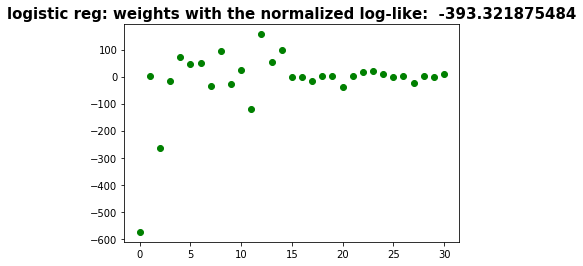

In [38]:
w, loss = func_logistic_reg (y=y_train, tx=tx_train, lambda_=lambda_best, test_set=tx_test, max_iters=50,\
                         gamma=gamma_best, initial_w=initial_w);



In [34]:
y_pred_train = predict_labels(w, tx_train)
right_train = np.sum(y_pred_train == y_train)/len(y_train)*100
right_train

71.364399999999989